### Exploratory Data Analysis of Epistasis Calculations
1. Results from using a linear model
2. Results from using the genotype estimated marginal means to calculate the GI definitions from Mani et al., 2008 PNAS

In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 1. Epistasis as the interaction term coefficient from the linear model

In [2]:
lin_res = pd.read_csv('../data/20240923_melissa_ara_data/corrected_data/fitness_data_for_Kenia_09232024_epistasis_linear.csv')
lin_res

,Set,e_est,lowerCI,upperCI,rsquared,pval_e,Label,Term,sw_test_stat,sw_test_pval,bp_test_stat,bp_test_pval,dw_test_stat,dw_test_pval,Epistasis_Direction
0,1,-3.420484,-13.060786,6.328656,0.020577,0.490694,PG,MA:MB,0.899520,6.759561e-12,NaN,0.192518,NaN,2.180000e-02,Not Detected
1,2,1.468086,-7.384080,10.363765,0.007616,0.746535,PG,MA:MB,0.921270,1.923475e-10,NaN,0.526144,NaN,3.822000e-01,Not Detected
2,3,0.733376,-10.331702,11.716566,0.018024,0.896592,PG,MA:MB,0.959331,1.667148e-06,NaN,0.100694,NaN,3.200000e-03,Not Detected
3,5,0.795857,-9.927141,11.744873,0.008208,0.885741,PG,MA:MB,0.988594,3.661914e-02,NaN,0.009404,NaN,3.576000e-01,Not Detected
4,7,-4.948922,-15.406394,5.637474,0.011038,0.358783,PG,MA:MB,0.894226,1.520047e-12,NaN,0.828178,NaN,9.594000e-01,Not Detected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,43,-0.368307,-1.088685,0.352071,0.030060,0.314287,SH_plog10,MA:MB,0.905436,3.949075e-09,8.057602,0.044836,1.663050,1.294761e-02,Not Detected
4644,794,0.180238,-0.688739,1.049215,0.000190,0.682849,SH_plog10,MA:MB,0.773384,1.018529e-15,3.367551,0.338351,1.472085,1.372717e-04,Not Detected
4645,807,0.725111,0.112011,1.338211,0.015436,0.020695,SH_plog10,MA:MB,0.598183,2.902488e-21,5.364732,0.146957,1.671091,1.055808e-02,Positive
4646,795,0.059341,-0.467759,0.586441,0.000183,0.824513,SH_plog10,MA:MB,0.430945,1.205561e-24,2.275597,0.517212,1.269928,1.385478e-07,Not Detected


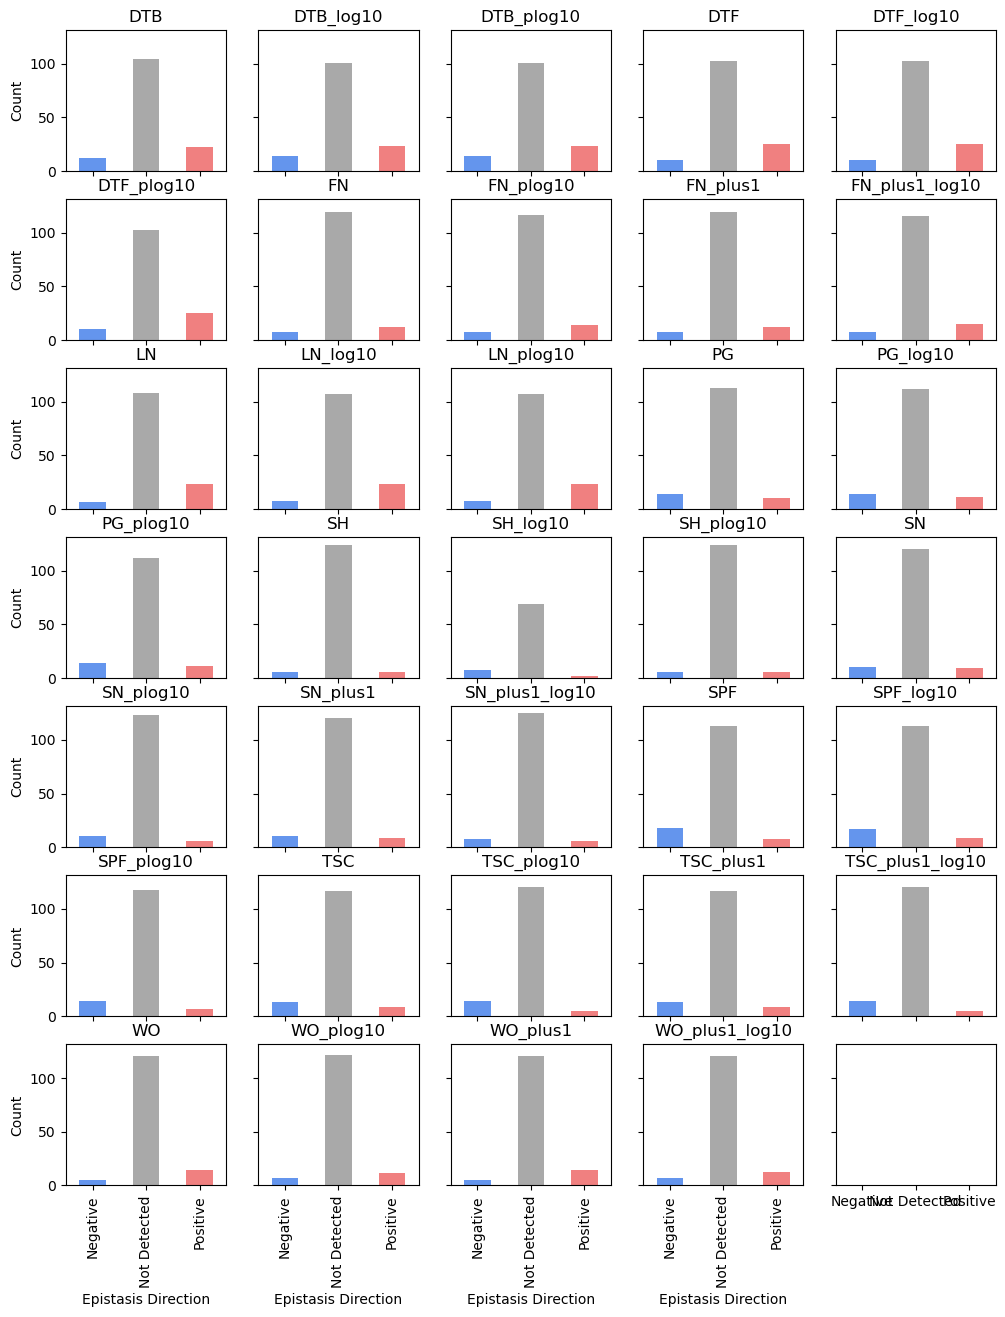

In [3]:
# How many sets per fitness label were found to exhibit epistasis?
lin_res_counts = lin_res.groupby(['Label', 'Epistasis_Direction'])['Set'].count().unstack()

fig, ax = plt.subplots(7, 5, figsize=(12, 15), sharex=True, sharey=True)
for i, (label, counts) in enumerate(lin_res_counts.iterrows()):
    counts.plot(kind='bar', ax=ax[i // 5, i % 5], title=label,
                color=['cornflowerblue', 'darkgray', 'lightcoral'])
    ax[i // 5, i % 5].set_ylabel('Count')
    ax[i // 5, i % 5].set_xlabel('Epistasis Direction')

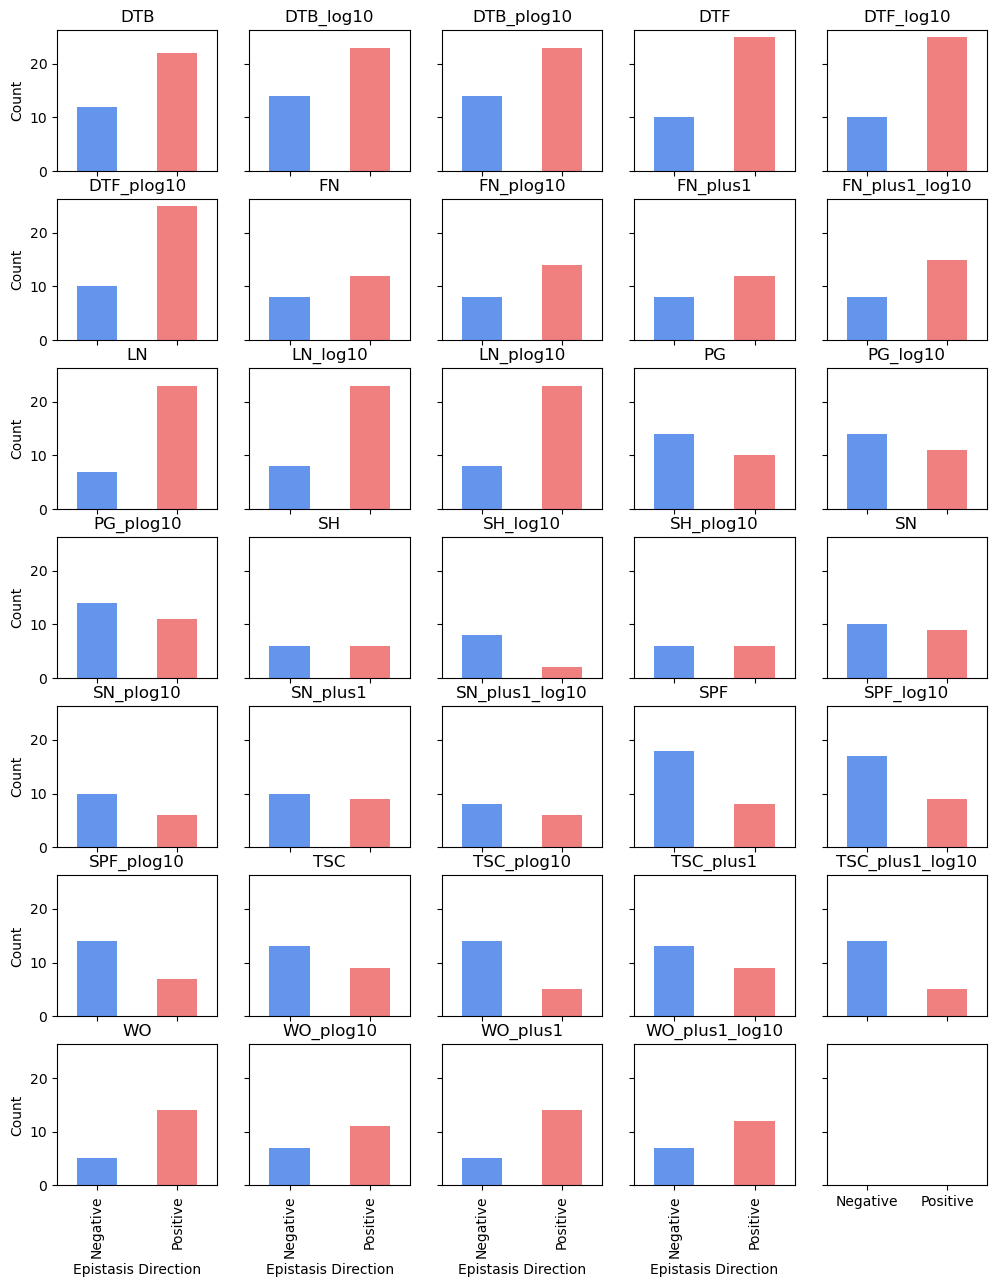

In [4]:
# Look only at the epistatic sets
fig, ax = plt.subplots(7, 5, figsize=(12, 15), sharex=True, sharey=True)
for i, (label, counts) in enumerate(lin_res_counts.drop(columns=['Not Detected']).iterrows()):
    counts.plot(kind='bar', ax=ax[i // 5, i % 5], title=label,
                color=['cornflowerblue', 'lightcoral'])
    ax[i // 5, i % 5].set_ylabel('Count')
    ax[i // 5, i % 5].set_xlabel('Epistasis Direction')

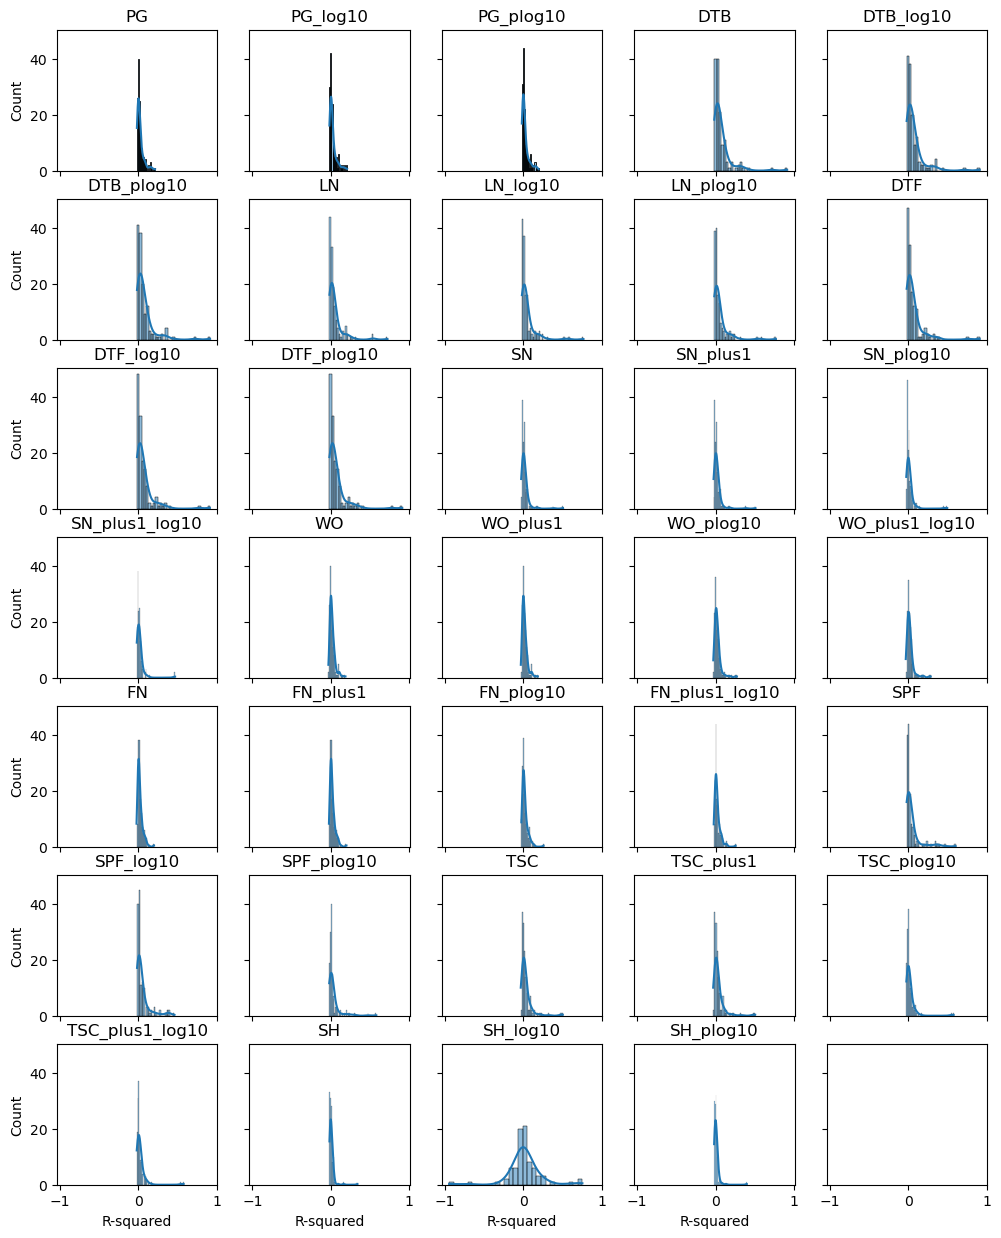

In [5]:
# What is the distribution of R-squared values? How much variance in each fitness label is explained by the models?
fig, ax = plt.subplots(7, 5, figsize=(12, 15), sharex=True, sharey=True)
for i, label in enumerate(lin_res['Label'].unique()):
    sns.histplot(lin_res[lin_res['Label'] == label]['rsquared'], ax=ax[i // 5, i % 5], kde=True)
    ax[i // 5, i % 5].set_title(label)
    ax[i // 5, i % 5].set_xlabel('R-squared')
    ax[i // 5, i % 5].set_ylabel('Count')

In [6]:
# Binary matrix specifying which sets exhibited significant epistasis interactions for each fitness label (1 = significant, 0 = not significant)
set_overlap = lin_res[lin_res['pval_e'] < 0.05].pivot_table(index='Label', columns='Set', values='pval_e', aggfunc='min').T
set_overlap[set_overlap < 0.05] = 1
set_overlap.fillna(0, inplace=True)
set_overlap

Label,DTB,DTB_log10,DTB_plog10,DTF,DTF_log10,DTF_plog10,FN,FN_plog10,FN_plus1,FN_plus1_log10,...,SPF_log10,SPF_plog10,TSC,TSC_plog10,TSC_plus1,TSC_plus1_log10,WO,WO_plog10,WO_plus1,WO_plus1_log10
Set,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
809,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# What is the overlap of sets with significant p-values between fitness labels?
set_overlap['Sum_across_labels'] = set_overlap.sum(axis=1)
set_overlap = pd.concat([set_overlap,
    set_overlap.sum(axis=0).rename('Sum_across_sets').to_frame().loc[set_overlap.columns].T],
    axis=0)
set_overlap

Label,DTB,DTB_log10,DTB_plog10,DTF,DTF_log10,DTF_plog10,FN,FN_plog10,FN_plus1,FN_plus1_log10,...,SPF_plog10,TSC,TSC_plog10,TSC_plus1,TSC_plus1_log10,WO,WO_plog10,WO_plus1,WO_plus1_log10,Sum_across_labels
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,16.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
12,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
823,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


<Figure size 640x480 with 0 Axes>

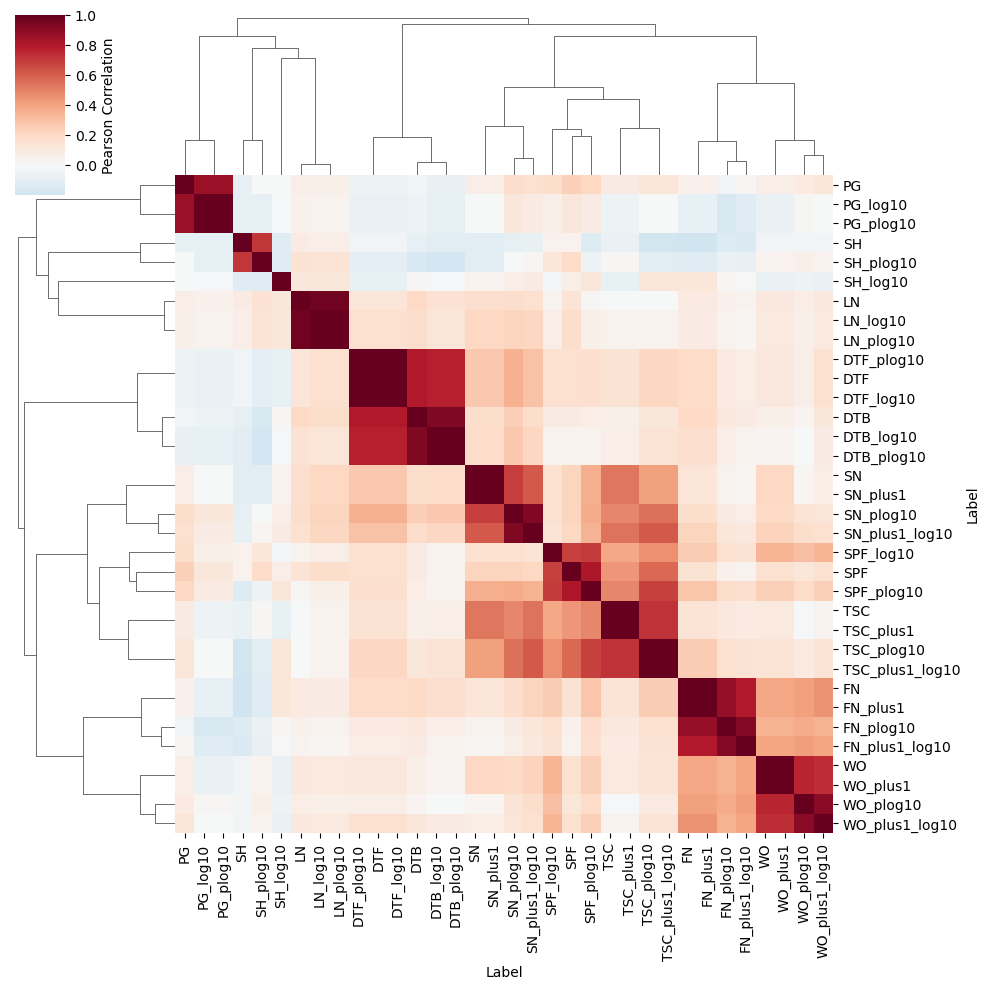

In [8]:
# Which fitness labels revealed epistasis in the same sets? (Pearson correlation)
fig = plt.figure()
sns.clustermap(set_overlap.iloc[:-1,:-1].corr(method='pearson'),
               cmap='RdBu_r', center=0, figsize=(10, 10), method='average',
               cbar_kws={'label': 'Pearson Correlation'})

In [9]:
# How many sets violated the assumptions of linear regression? 1 = violated, 0 = not violated
lin_res['Normality_Violated'] = np.where(lin_res['sw_test_pval'] < 0.05, 1, 0)
lin_res['Homoscedasticity_Violated'] = np.where(lin_res['bp_test_pval'] < 0.05, 1, 0)

violations = lin_res[['Set', 'Label', 'Normality_Violated', 'Homoscedasticity_Violated']].\
    pivot_table(index='Set', columns='Label', values=['Normality_Violated', 'Homoscedasticity_Violated'],
    aggfunc='first')

violations['Homoscedasticity_Violated_Sum'] = violations['Homoscedasticity_Violated'].sum(axis=1)
violations['Normality_Violated_Sum'] = violations['Normality_Violated'].sum(axis=1)

violations = pd.concat([violations,
    violations.sum(axis=0).rename('Sum_across_sets').to_frame().loc[violations.columns].T],
    axis=0)
violations

Homoscedasticity_Violated                             \
Label                                 DTB DTB_log10 DTB_plog10   DTF   
1                                     1.0       0.0        0.0   0.0   
2                                     0.0       1.0        1.0   1.0   
3                                     0.0       0.0        0.0   0.0   
5                                     0.0       0.0        0.0   0.0   
7                                     0.0       0.0        0.0   0.0   
...                                   ...       ...        ...   ...   
812                                   0.0       0.0        0.0   0.0   
813                                   0.0       0.0        0.0   0.0   
815                                   0.0       0.0        0.0   0.0   
823                                   1.0       1.0        1.0   1.0   
Sum_across_sets                      13.0      15.0       15.0  13.0   

                                                                              \
Label           DTF_log10 DTF_plog10    FN FN_plog10 FN_plus1 FN_plus1_log10   
1                     0.0        0.0   0.0       0.0      0.0            0.0   
2                     1.0        1.0   0.0       0.0      0.0            0.0   
3                     0.0        0.0   0.0       0.0      0.0            0.0   
5                     0.0        0.0   0.0       0.0      0.0            0.0   
7                     0.0        0.0   0.0       0.0      0.0            0.0   
...                   ...        ...   ...       ...      ...            ...   
812                   0.0        0.0   0.0       0.0      0.0            0.0   
813                   0.0        0.0   1.0       1.0      1.0            1.0   
815                   0.0        0.0   0.0       0.0      0.0            0.0   
823                   1.0        1.0   0.0       0.0      0.0            0.0   
Sum_across_sets      15.0       15.0  26.0      30.0     26.0           32.0   

                 ... Normality_Violated                                       \
Label            ...                TSC TSC_plog10 TSC_plus1 TSC_plus1_log10   
1                ...                1.0        1.0       1.0             1.0   
2                ...                1.0        1.0       1.0             1.0   
3                ...                1.0        1.0       1.0             1.0   
5                ...                1.0        1.0       1.0             1.0   
7                ...                1.0        1.0       1.0             1.0   
...              ...                ...        ...       ...             ...   
812              ...                0.0        1.0       0.0             1.0   
813              ...                1.0        0.0       1.0             0.0   
815              ...                1.0        1.0       1.0             1.0   
823              ...                1.0        1.0       1.0             1.0   
Sum_across_sets  ...              103.0      138.0     103.0           138.0   

                                                          \
Label               WO WO_plog10 WO_plus1 WO_plus1_log10   
1                  1.0       1.0      1.0            1.0   
2                  1.0       1.0      1.0            1.0   
3                  1.0       1.0      1.0            1.0   
5                  1.0       1.0      1.0            1.0   
7                  1.0       1.0      1.0            1.0   
...                ...       ...      ...            ...   
812                1.0       1.0      1.0            1.0   
813                1.0       1.0      1.0            1.0   
815                1.0       1.0      1.0            1.0   
823                1.0       1.0      1.0            1.0   
Sum_across_sets  138.0     139.0    138.0          139.0   

                Homoscedasticity_Violated_Sum Normality_Violated_Sum  
Label                                                                 
1                                         3.0                   31.0  
2  

Text(0.5, 1.0, 'Homoscedasticity Violations')

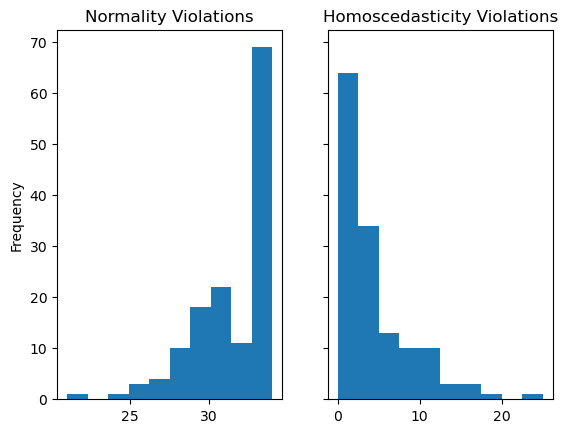

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
violations[['Normality_Violated_Sum']].iloc[:-1].plot(kind='hist', ax=ax[0], legend=False)
ax[0].set_title('Normality Violations')

violations[['Homoscedasticity_Violated_Sum']].iloc[:-1].plot(kind='hist', ax=ax[1], legend=False)
ax[1].set_title('Homoscedasticity Violations')


#### 2. Epistasis as the GI definitions